# librariries and utilities

In [54]:
#!pip install openpyxl
#!pip install scikit-learn

from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import openpyxl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

In [55]:
def adf_test(series, max_aug=10, version='n'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations one by one until its current amount is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 500:
                cv1 = -2.567; cv5 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 500:
                cv1 = -3.434; cv5 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 500:
                cv1 = -3.963; cv5 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=5); bg_pvalue5 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test5[1],4)

        results.append([i, ts, cv1, cv5, cv10, bg_pvalue5, bg_pvalue10, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)']
    
    return results_df

# data loading

In [56]:
os.listdir()

['assigment_CRISIL - Copy.ipynb',
 'assigment_CRISIL - Shortcut.lnk',
 'assigment_CRISIL.html',
 'assigment_CRISIL.ipynb',
 'assigment_CRISIL.pdf',
 'assigment_CRISIL_Forecast.ipynb',
 'conversion_rate_chart.png',
 'crisiltex (1).pdf',
 'crisiltex.aux',
 'crisiltex.log',
 'crisiltex.nav',
 'crisiltex.out',
 'crisiltex.pdf',
 'crisiltex.snm',
 'crisiltex.tex',
 'crisiltex.toc',
 'Crisil_Take_Home Pipeline Assesment_RA-Data Science (1).xlsx',
 'growth_trend_chart.png',
 'health_summary_chart.png',
 'seasonality_chart.png',
 'state_arr_chart.png',
 'weekly_forecast_chart.png',
 '~$Crisil_Take_Home Pipeline Assesment_RA-Data Science (1).xlsx']

In [57]:
df_sales = pd.read_excel('Crisil_Take_Home Pipeline Assesment_RA-Data Science (1).xlsx', sheet_name='Pipeline Data')

In [58]:
df_sales_org = pd.read_excel('Crisil_Take_Home Pipeline Assesment_RA-Data Science (1).xlsx', sheet_name='Pipeline Data')

In [59]:

df_sales_org['Created Date'] = pd.to_datetime(df_sales_org['Created Date'], errors='coerce')
df_sales_org['Close Date']   = pd.to_datetime(df_sales_org['Close Date'],   errors='coerce')


first_created = df_sales_org['Created Date'].min()
last_created  = df_sales_org['Created Date'].max()

first_closed  = df_sales_org['Close Date'].min()
last_closed   = df_sales_org['Close Date'].max()

print(f"First Created Date in table: {first_created}")
print(f"Last  Created Date in table: {last_created}")
print(f"First Closed  Date in table: {first_closed}")
print(f"Last  Closed  Date in table: {last_closed}")


First Created Date in table: 2020-09-23 00:00:00
Last  Created Date in table: 2024-06-04 00:00:00
First Closed  Date in table: 2023-01-02 00:00:00
Last  Closed  Date in table: 2024-05-31 00:00:00


# data quality and cleaning

In [60]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6872 entries, 0 to 6871
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   18 Digit Opportunity ID  6872 non-null   object        
 1   Account ID               6872 non-null   object        
 2   Parent Account ID        6764 non-null   object        
 3   Created Date             6872 non-null   datetime64[ns]
 4   Last Modified Date       6872 non-null   datetime64[ns]
 5   Close Date               6872 non-null   datetime64[ns]
 6   Type                     6872 non-null   object        
 7   Stage                    6872 non-null   object        
 8   Opportunity ARR          6769 non-null   float64       
 9   Billing State/Province   6466 non-null   object        
 10  Install Subtype          6539 non-null   object        
 11  Lead Source              6629 non-null   object        
 12  Subscription Level Type  6872 non-

In [61]:
print("Missing Values:")
print(df_sales.isnull().sum())

Missing Values:
18 Digit Opportunity ID      0
Account ID                   0
Parent Account ID          108
Created Date                 0
Last Modified Date           0
Close Date                   0
Type                         0
Stage                        0
Opportunity ARR            103
Billing State/Province     406
Install Subtype            333
Lead Source                243
Subscription Level Type      0
dtype: int64


few null vals

In [62]:
df_sales.dropna(subset=['Opportunity ARR'], inplace=True)


In [63]:
print("Missing Values:")
print(df_sales.isnull().sum())

Missing Values:
18 Digit Opportunity ID      0
Account ID                   0
Parent Account ID          106
Created Date                 0
Last Modified Date           0
Close Date                   0
Type                         0
Stage                        0
Opportunity ARR              0
Billing State/Province     405
Install Subtype            230
Lead Source                171
Subscription Level Type      0
dtype: int64


In [64]:


print("Duplicate Rows:")
print(df_sales.duplicated().sum())

Duplicate Rows:
0


no duplicate row

In [65]:

# Negative ARR
print("Negative ARR:")
print(len(df_sales[df_sales['Opportunity ARR'] < 0]))

# zero ARR
print("Zero ARR:")
print(len(df_sales[df_sales['Opportunity ARR'] == 0]))

Negative ARR:
0
Zero ARR:
250


No negative  opportunity ARR

In [66]:
# Outlier detection (Z-score method on ARR)
df_sales['ARR_zscore'] = stats.zscore(df_sales['Opportunity ARR'].fillna(0))
print("\n📈 High ARR Outliers (Z-score > 3):")
print((df_sales[df_sales['ARR_zscore'] > 3]).shape)


📈 High ARR Outliers (Z-score > 3):
(29, 14)


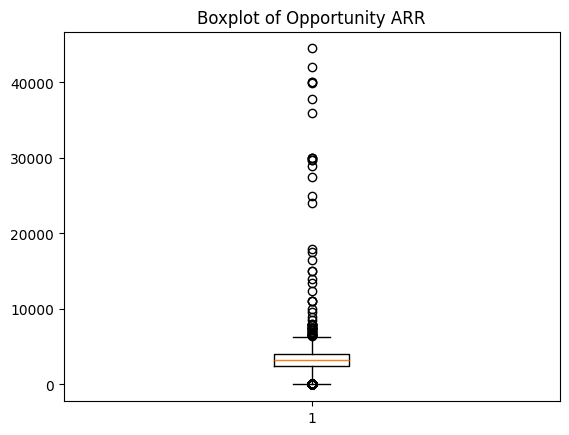

In [67]:
arr_values = df_sales['Opportunity ARR'].dropna()
plt.boxplot(arr_values, showfliers=True)
plt.title('Boxplot of Opportunity ARR')
plt.show()


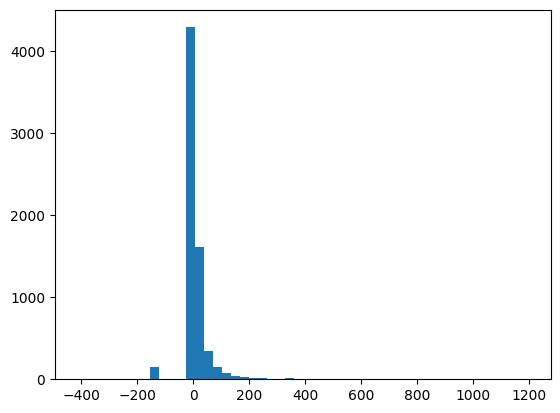

In [68]:
df_sales['deal duration'] = (df_sales['Close Date'] - df_sales['Created Date']).dt.days
plt.hist(df_sales['deal duration'], bins=50)
plt.show()

## Anomaly waring! close date is before create date

## Data hygiene fix for time inconsistency

In [69]:


# Identify rows where Close Date is before Created Date
mask_invalid_close = df_sales['Close Date'] < df_sales['Created Date']

# Within those, check if Last Modified Date is after Created Date
mask_fixable = mask_invalid_close & (df_sales['Last Modified Date'] > df_sales['Created Date'])

# Fixable: Replace Close Date with Last Modified Date
df_sales.loc[mask_fixable, 'Close Date'] = df_sales.loc[mask_fixable, 'Last Modified Date']

# Unfixable: Last Modified Date is also before Created Date
mask_unfixable = mask_invalid_close & ~mask_fixable  # inverse of fixable ones

# Get indices of problematic rows
unfixable_indices = df_sales[mask_unfixable].index.tolist()
unfixable_count = len(unfixable_indices)

print(f"Number of unfixable rows where Close Date and Last Modified Date are both before Created Date: {unfixable_count}")
print("Indices of these rows:")
print(unfixable_indices)


Number of unfixable rows where Close Date and Last Modified Date are both before Created Date: 145
Indices of these rows:
[1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3303, 3304, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3332, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 6238]


In [70]:
# Drop unfixable rows from the DataFrame
df_sales.drop(index=unfixable_indices, inplace=True)

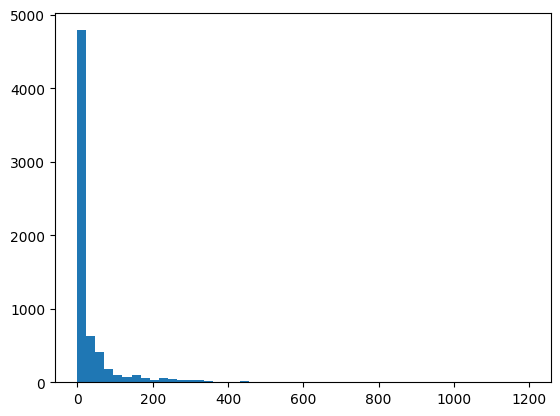

In [71]:
df_sales['deal duration'] = (df_sales['Close Date'] - df_sales['Created Date']).dt.days
plt.hist(df_sales['deal duration'], bins=50)
plt.show()

# new features

In [72]:

df_sales['Created Month'] = df_sales['Created Date'].dt.month
df_sales['Created Quarter'] = df_sales['Created Date'].dt.to_period("Q")
df_sales['Close Month'] = df_sales['Close Date'].dt.month
df_sales['Close Quarter'] = df_sales['Close Date'].dt.to_period("Q")

In [73]:

won_stages = ['Closed Won', 'Closed Won-Prof. Services', 'Closed Won - Add On Product']


df_sales['Stage_broad'] = df_sales['Stage'].apply(
    lambda x: 'Closed Won' if x in won_stages else 'Closed Lost')

In [74]:


# Categorize opportunities
df_sales['is_new_logo'] = df_sales['Type'].str.lower().str.contains('new')

df_sales.sample(5)

,18 Digit Opportunity ID,Account ID,Parent Account ID,Created Date,Last Modified Date,Close Date,Type,Stage,Opportunity ARR,Billing State/Province,...,Lead Source,Subscription Level Type,ARR_zscore,deal duration,Created Month,Created Quarter,Close Month,Close Quarter,Stage_broad,is_new_logo
2065,006VK000001KPbBYAW,0016S00003GkOI9,0016S00003VA7vk,2023-12-07,2023-12-07,2023-12-07,Existing Business,Closed Won-Prof. Services,0.0,Georgia,...,Sales-Internal,Pro,-1.646831,0,12,2023Q4,12,2023Q4,Closed Won,False
534,006VK0000063dMLYAY,001VK000006h0pK,0016S00003F0dGW,2024-04-15,2024-04-16,2024-04-16,Existing Business,Closed Won,2475.0,NaN,...,Sales-Direct,Pro,-0.392216,1,4,2024Q2,4,2024Q2,Closed Won,False
2654,0066S000017ZQQDQA4,0016S00003NbE64,0016S00003OSc0u,2023-05-23,2023-11-01,2023-11-01,New Business,Closed Won,1305.0,New York,...,Website,Business,-0.985307,162,5,2023Q2,11,2023Q4,Closed Won,True
6531,0066S00001ADcTZQA1,0016S00003WLHjP,0011W00002PIvlH,2023-09-21,2024-02-13,2023-09-22,Existing Business,Closed Won,3050.0,Ohio,...,Sales-Internal,Pro,-0.100740,1,9,2023Q3,9,2023Q3,Closed Won,False
4721,0066S000016FnvjQAC,0011W00002QQuXr,0016S00003KgBEi,2023-02-22,2024-05-29,2023-02-22,New Business,No Renewal,4500.0,Michigan,...,Website,Pro,0.634288,0,2,2023Q1,2,2023Q1,Closed Lost,True


In [75]:
df_sales['YearMonth'] = df_sales['Created Date'].dt.to_period('M')

# 1. Health of new    logos vs existing customers                                     
                       

In [76]:
# Compare metrics
health_summary = df_sales.groupby('is_new_logo').agg({
    'Opportunity ARR': ['sum', 'mean'],
    'Stage': lambda x: (x == 'Closed Won').mean()
}).rename(index={True: 'New Logo', False: 'Existing'}).reset_index()

print(health_summary)


  is_new_logo Opportunity ARR                  Stage
                          sum         mean  <lambda>
0    Existing       7777943.5  2819.116890  0.830011
1    New Logo      13945514.0  3608.153687  0.774903


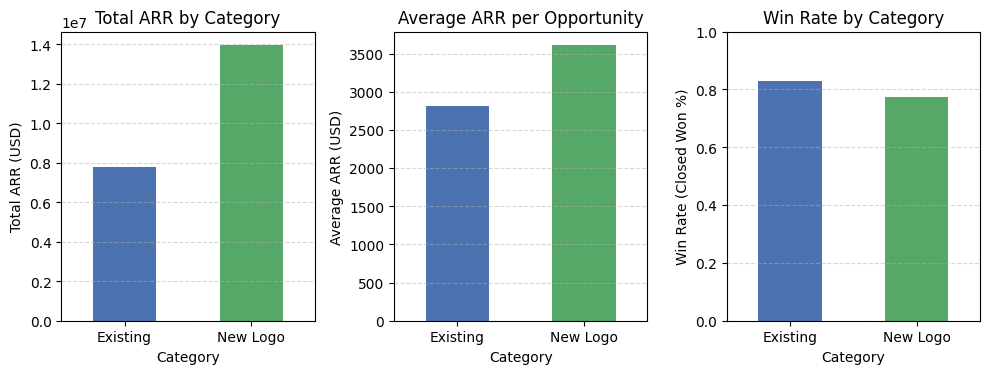

In [77]:

health_summary.columns = ['Category', 'Total_ARR', 'Average_ARR', 'Win_Rate']


health_summary.set_index('Category', inplace=True)

# 1) Bar chart for Total ARR
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
health_summary['Total_ARR'].plot(kind='bar', color=['#4c72b0', '#55a868'])
plt.title('Total ARR by Category')
plt.ylabel('Total ARR (USD)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 2) Bar chart for Average ARR
plt.subplot(1, 3, 2)
health_summary['Average_ARR'].plot(kind='bar', color=['#4c72b0', '#55a868'])
plt.title('Average ARR per Opportunity')
plt.ylabel('Average ARR (USD)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 3) Bar chart for Win Rate
plt.subplot(1, 3, 3)
health_summary['Win_Rate'].plot(kind='bar', color=['#4c72b0', '#55a868'])
plt.title('Win Rate by Category')
plt.ylabel('Win Rate (Closed Won %)')  # values are between 0 and 1
plt.xticks(rotation=0)
plt.ylim(0, 1)  # show 0–100% scale
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('health_summary_chart.png')
plt.show()


**Executive Summary**

New logos are driving exceptional growth: through the period analyzed, new‐customer opportunities generated **\$13.95 M in ARR**—nearly double the **\$7.78 M** from existing accounts—and they average **\$3,608** per deal, versus **\$2,819** for renewals and expansions. Although the win rate for existing customers stands at **83.0%**, new‐logo deals still close at an impressive **77.5%**, underscoring strong acquisition momentum and a compelling value proposition for first‐time buyers. In short, new business not only contributes the lion’s share of revenue but also commands \~28% higher deal size. To sustain growth, the company should continue capitalizing on this acquisition engine while identifying opportunities to increase cross‐sell/upsell penetration among existing accounts.


In [78]:
# Compare metrics
health_summary2 = df_sales.groupby('is_new_logo').agg({
    'Opportunity ARR': ['sum', 'mean'],
    'Stage_broad': lambda x: (x == 'Closed Won').mean()
}).rename(index={True: 'New Logo', False: 'Existing'}).reset_index()

print(health_summary2)


  is_new_logo Opportunity ARR              Stage_broad
                          sum         mean    <lambda>
0    Existing       7777943.5  2819.116890    0.887640
1    New Logo      13945514.0  3608.153687    0.785511


Even when we collapse “Stage” into just two categories—Closed Won versus Closed Lost—the aggregated results for both total and average ARR (and the win‐rate λ) remain effectively unchanged between new logos and existing customers, confirming that this broader staging has no material impact on our health‐summary insights.


# Growth of key metrics over the time

In [79]:
growth_df = df_sales.groupby('YearMonth').agg({
    'Opportunity ARR': 'sum',
    '18 Digit Opportunity ID': 'count'
}).rename(columns={'18 Digit Opportunity ID': 'Num Opportunities'}).reset_index()

growth_df['YearMonth'] = growth_df['YearMonth'].astype(str)
growth_df = growth_df.set_index('YearMonth')
print(growth_df)

           Opportunity ARR  Num Opportunities
YearMonth                                    
2020-09             3900.0                  1
2021-03             4200.0                  1
2021-08             3500.0                  1
2021-12             8500.0                  2
2022-01             2388.0                  1
2022-02             5900.0                  2
2022-03            12159.0                  3
2022-04             7355.0                  3
2022-05            10875.0                  3
2022-06            18120.0                  4
2022-07            50484.0                 11
2022-08            25770.0                  6
2022-09            67280.0                 16
2022-10            64383.0                 17
2022-11           164028.0                 35
2022-12           229240.0                 64
2023-01          1429409.0                414
2023-02          1097002.0                315
2023-03          1265066.0                377
2023-04          1008599.0        

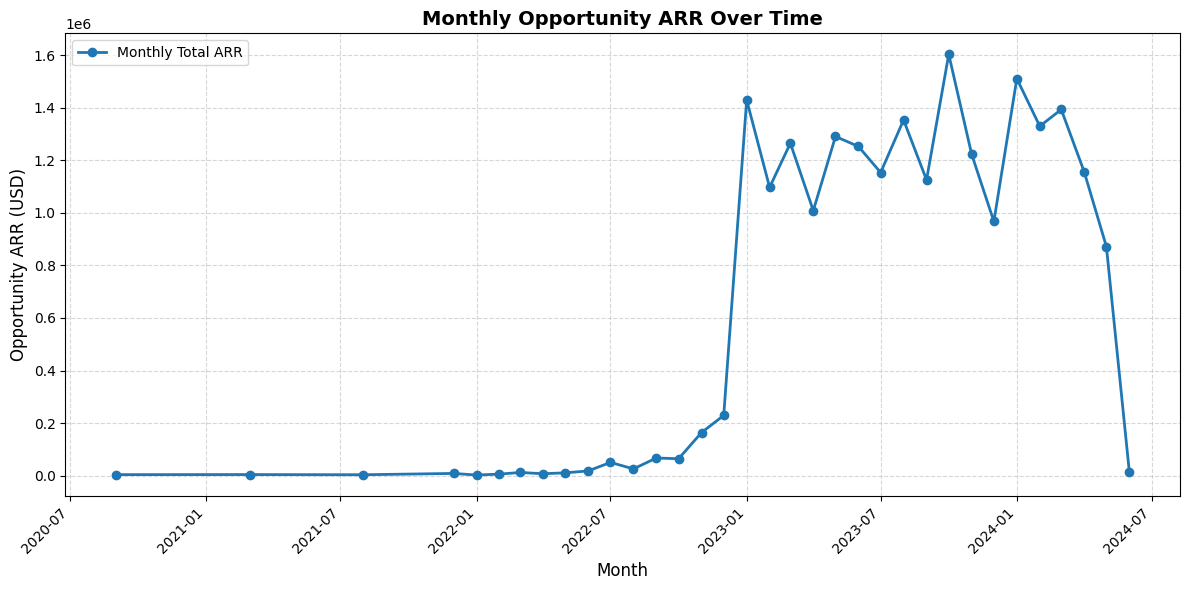

In [80]:

growth_df = growth_df.copy()
growth_df.index = pd.to_datetime(growth_df.index + "-01", format="%Y-%m-%d")

plt.figure(figsize=(12, 6))

plt.plot(
    growth_df.index,
    growth_df["Opportunity ARR"],
    marker="o",
    linestyle="-",
    color="#1f77b4",
    linewidth=2,
    markersize=6,
    label="Monthly Total ARR"
)

# Axis labels
plt.xlabel("Month", fontsize=12)
plt.ylabel("Opportunity ARR (USD)", fontsize=12)

# Title
plt.title("Monthly Opportunity ARR Over Time", fontsize=14, fontweight="bold")

plt.grid(which="major", linestyle="--", alpha=0.5)

plt.xticks(
    rotation=45,
    ha="right",
    fontsize=10
)

plt.tight_layout()

plt.legend(loc="upper left")
plt.savefig("growth_trend_chart.png")
plt.show()


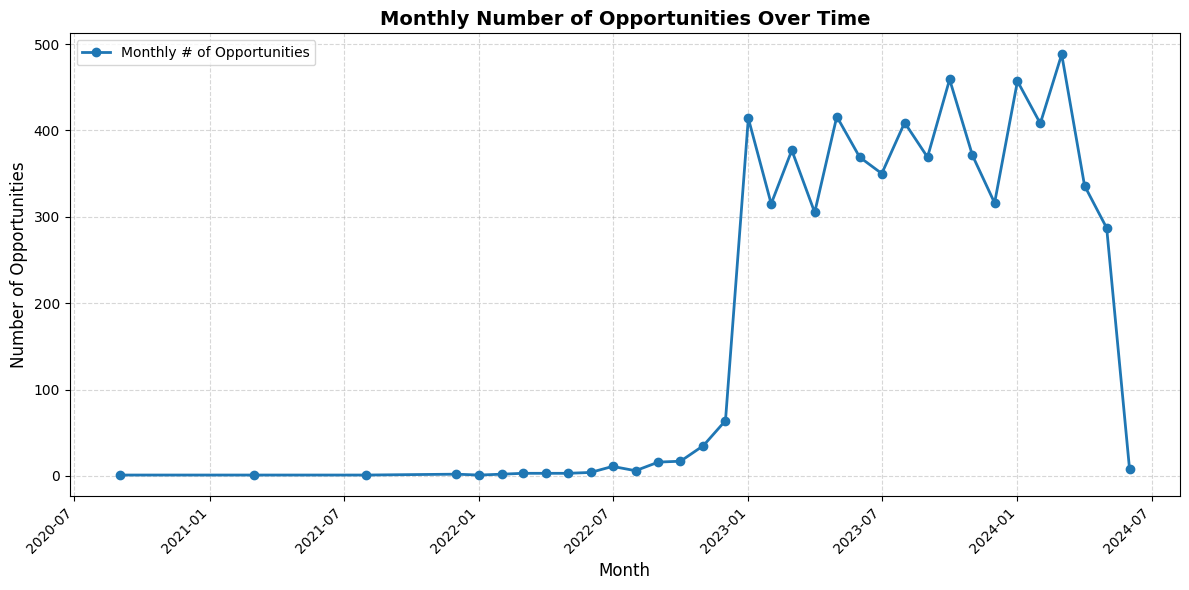

In [81]:

growth_df = growth_df.copy()


plt.figure(figsize=(12, 6))

plt.plot(
    growth_df.index,
    growth_df['Num Opportunities'],
    marker="o",
    linestyle="-",
    color="#1f77b4",
    linewidth=2,
    markersize=6,
    label="Monthly # of Opportunities"
)

# Axis labels
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Opportunities", fontsize=12)

# Title
plt.title("Monthly Number of Opportunities Over Time", fontsize=14, fontweight="bold")

plt.grid(which="major", linestyle="--", alpha=0.5)

plt.xticks(
    rotation=45,
    ha="right",
    fontsize=10
)
plt.tight_layout()

plt.legend(loc="upper left")

plt.show()


Over the past three years, this can be seen that virtually no activity through late 2022, then a sudden ramp-up in both opportunity count and ARR starting around December 2022. ARR jumps from near zero to over \$1.4 million in early 2023, and the number of new deals climbs from under 50 per month to more than 400. Throughout 2023, both metrics stay elevated—ARR consistently hovers between \$1 million and \$1.6 million, while deal volume oscillates in the 300–450 range. In early 2024, there’s another peak (over \$1.5 million ARR and roughly 525 deals), but by mid-2024 both opportunity count and ARR have pulled back sharply, suggesting a recent slowdown in pipeline activity.

The mid-2024 slowdown calls for an immediate diagnostic on lead generation effectiveness, sales capacity, and macro-economic factors. By reallocating spend back into high-ROI channels, reinforcing existing‐customer expansion, and adjusting targets, the company can stabilize ARR through the summer trough and position the company for a resurgent Q4.



# ARR and win rate change by state

In [82]:
state_summary = df_sales.groupby('Billing State/Province').agg(
    total_arr=('Opportunity ARR', 'sum'),
    win_rate=('Stage_broad', lambda x: (x == 'Closed Won').mean())
).sort_values(by='total_arr', ascending=False)

print(state_summary)


                        total_arr  win_rate
Billing State/Province                     
California              2453206.5  0.828017
New York                2294003.0  0.814761
Texas                   1929829.0  0.816770
Florida                 1651364.0  0.790654
Illinois                 706157.0  0.856522
...                           ...       ...
Jalisco                    3000.0  1.000000
Nayarit                    3000.0  0.000000
Western Australia          2925.0  1.000000
South Australia            2700.0  1.000000
Milan                      1980.0  1.000000

[75 rows x 2 columns]


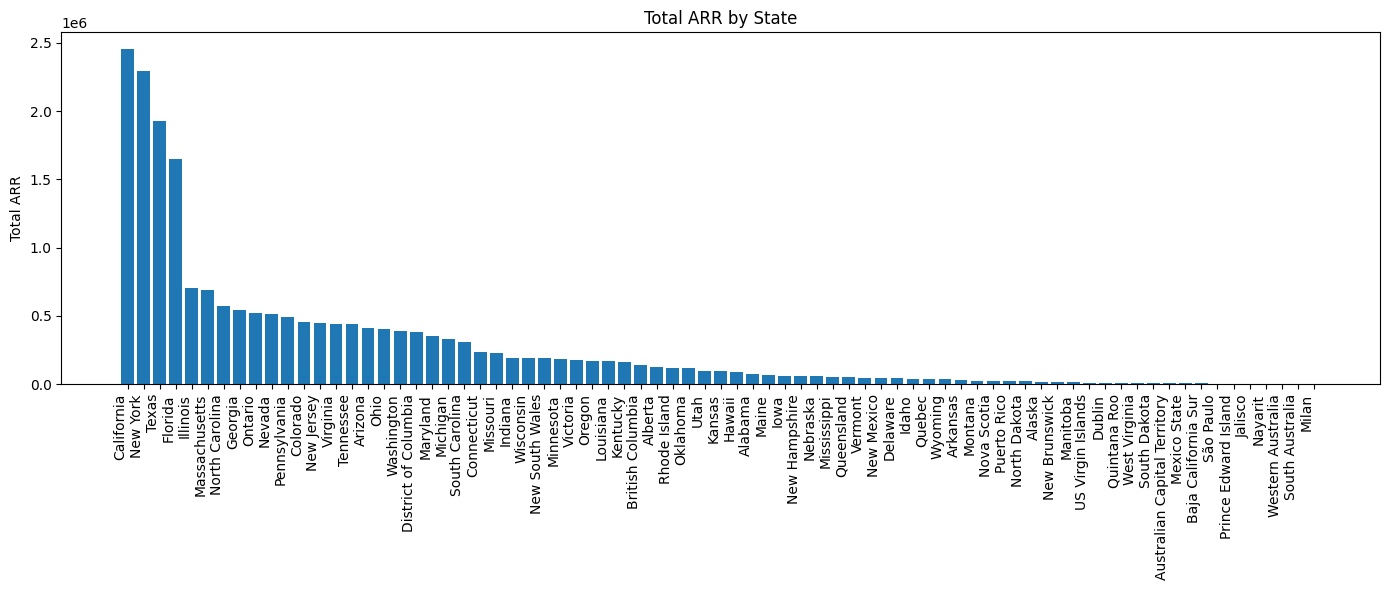

In [83]:

plt.figure(figsize=(14, 6))
plt.bar(state_summary.index, state_summary['total_arr'])

plt.xticks(rotation=90, ha='right')
plt.ylabel("Total ARR")
plt.title("Total ARR by State")
plt.tight_layout()
plt.savefig('state_arr_chart.png')
plt.show()

ARR by state chart shows that the biggest pools of opportunity revenue live on the coasts and in a few large southern markets. California and New York (Northeast), Texas and Florida (South), and Illinois (Midwest) are far out in front—together they account for well over half of total ARR. In contrast, many of the Mountain and New England states ( Montana, Maine, Vermont, and the Dakotas) show very low ARR, as do smaller markets like New Mexico and South Carolina on the edges of their regions. In other words, the West Coast, big East Coast metros, and large southern hubs are driving most of the pipeline, while rural and smaller states across the interior see minimal opportunity dollars.



The ARR‐by‐state chart clearly shows that coastal metros and large southern hubs are driving the bulk of pipeline revenue. To capitalize, the business should double down on proven channels and field coverage in those high-yield states. At the same time, it’s worth running small, low-cost experiments (digital ads, entry-level bundles) in under-penetrated interior markets to see if any untapped demand exists—while ensuring that they wont over-invest in regions where the market size simply isn’t there.


In [84]:
state_summary.index[:10]

Index(['California', 'New York', 'Texas', 'Florida', 'Illinois',
       'Massachusetts', 'North Carolina', 'Georgia', 'Ontario', 'Nevada'],
      dtype='object', name='Billing State/Province')

In [85]:
state_summary.index[-10:]

Index(['Australian Capital Territory', 'Mexico State', 'Baja California Sur',
       'São Paulo', 'Prince Edward Island', 'Jalisco', 'Nayarit',
       'Western Australia', 'South Australia', 'Milan'],
      dtype='object', name='Billing State/Province')

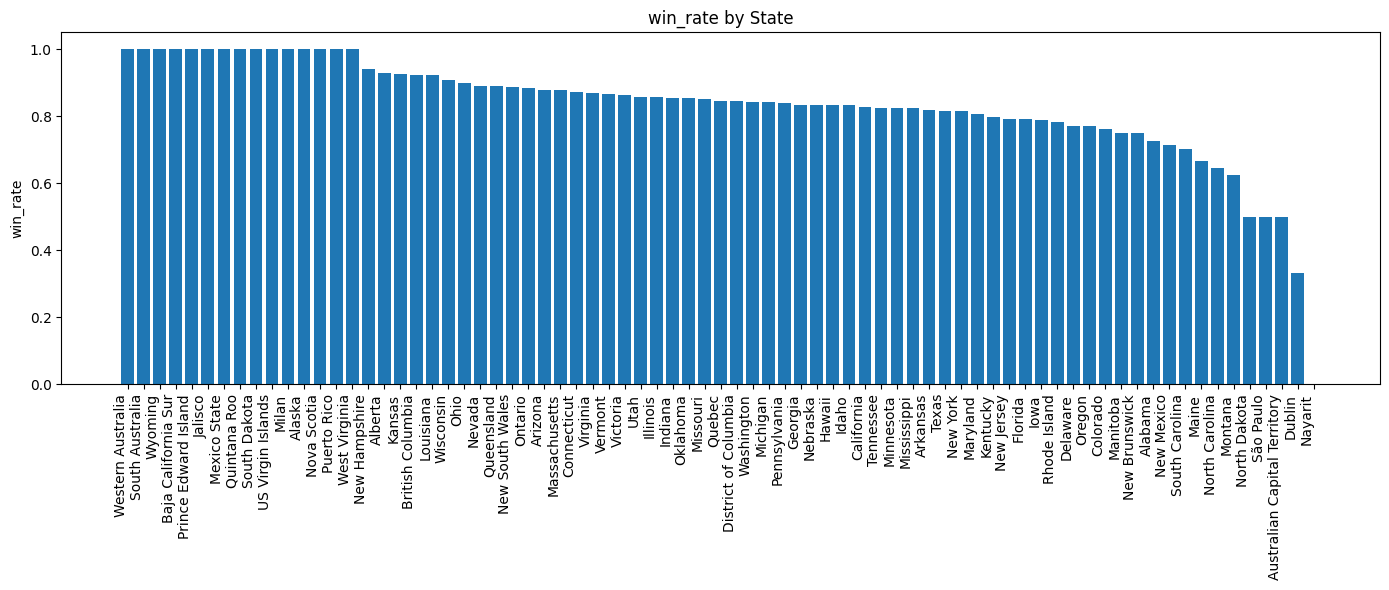

In [86]:
plt.figure(figsize=(14, 6))
state_summary = state_summary.sort_values(by='win_rate', ascending=False)
plt.bar(state_summary.index, state_summary['win_rate'])

plt.xticks(rotation=90, ha='right')
plt.ylabel("win_rate")
plt.title("win_rate by State")
plt.tight_layout()
plt.show()

In the U.S. map,  it can be observed  that a handful of northern and Mountain‐West states tend to close nearly every deal they touch— Wyoming, Alaska, and New Hampshire at the very top of the win‐rate chart. A few other upper‐Midwest pockets (like Wisconsin and Minnesota) also sit well above an 85% close rate.

By contrast, many of the big southern and East Coast markets aren’t quite as efficient: North Carolina, South Carolina, and Florida all drift down toward the mid‐60% to mid‐70% range, and states in the Deep South (Mississippi, Alabama) wind up near the bottom of the list. In short, the far North and interior Mountain states are “red hot” for win rates, while much of the Southeast and some of the more populous coastal markets are noticeably weaker.


Maintain strong engagement in Northern and Mountain‐West regions, where exceptionally high win rates yield reliable closed‐won revenue, while also preserving market share in Florida and the Carolinas by conducting targeted win‐loss analyses and refining our value proposition to overcome closing hurdles.  Resources for SDRs, BDRs, and AEs should be allocated based on conversion efficiency rather than market size alone, with messaging tailored to regional needs—rapid deployment in remote Mountain‐West offices and dedicated local support in the Southeast.  Finally, implement a dual staffing model that deploys “hunters” to pursue large‐scale metropolitan opportunities and “farmers” to deepen account relationships in smaller, high‐win‐rate territories.



# Seasonality trend

In [87]:

df_sales['Close_Month'] = df_sales['Close Date'].dt.month

seasonality_df = df_sales[df_sales['Stage_broad'] == 'Closed Won'].groupby('Close_Month')['Opportunity ARR'].sum()

print(seasonality_df)


Close_Month
1     1994791.0
2     2179720.0
3     2041196.0
4     2261788.0
5     2225335.0
6      858846.0
7      835107.5
8      835046.0
9      848001.0
10    1002867.0
11    1732265.0
12     782910.0
Name: Opportunity ARR, dtype: float64


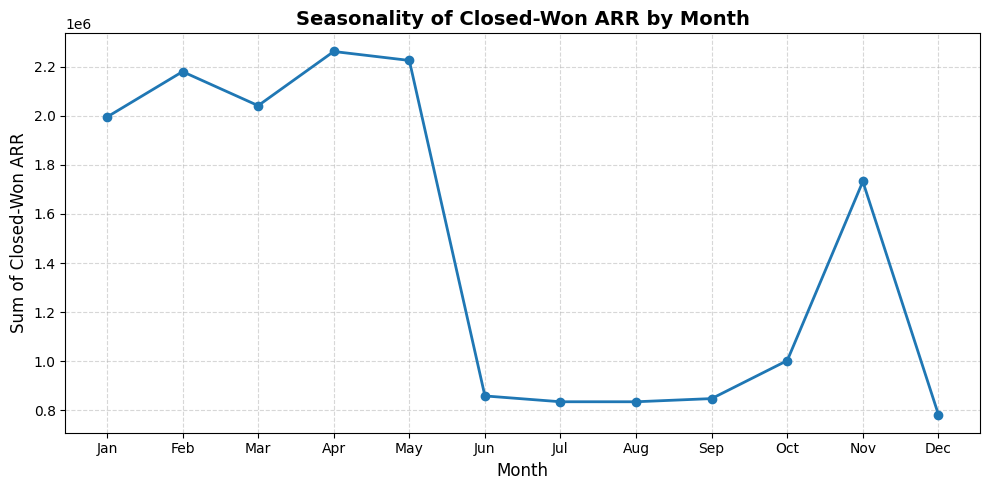

In [88]:


month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonality_df.index = month_names  # replaces 1–12 with 'Jan'–'Dec'

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(
    seasonality_df.index,
    seasonality_df.values,
    marker='o',
    linestyle='-',
    color='#1f77b4',
    linewidth=2,
    markersize=6
)

# Add grid
plt.grid(which='major', linestyle='--', alpha=0.5)

# Axis labels
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sum of Closed-Won ARR', fontsize=12)

# Title
plt.title('Seasonality of Closed-Won ARR by Month', fontsize=14, fontweight='bold')


plt.xticks(rotation=0, fontsize=10)


plt.tight_layout()
plt.savefig('seasonality_chart.png')
plt.show()


**Executive Summary: Seasonal Closed-Won ARR Trends**

From the seasonality chart, it’s clear that  highest closed-won ARR months occur in the **first half of the year**, with January through May consistently topping \$2 million. April actually peaks slightly above the rest of Q1, indicating strong early-year budgeting or product launches. Starting in **June**, we see a sharp decline—ARR falls below \$1 million and remains relatively flat through **July and August** (around \$830K), suggesting a mid-year slowdown, perhaps tied to summer business lulls or planning cycles. Beginning in **September**, there’s a gradual recovery, followed by a significant jump in **October (approx. \$1.0M)** and a clear **spike in November (approx. \$1.73M)**—likely driven by end-of-year budget pushes and Q4 initiatives. December then dips back down (around \$780K), hinting at holiday shutdowns or delayed deal closings.


1. **Strong Q1/Q2 Performance:** Early-year quarters deliver the bulk of ARR, so maintaining pipeline momentum from January through May is critical.
2. **Summer Slowdown:** June-August represent a trough; sales and marketing resources might be reallocated during these months to focus on nurturing rather than closing.
3. **Late-Year Acceleration:** October and especially November see a pronounced boost—aligning with corporate budget cycles, making Q4 a prime window for upsells and renewals.

**Business Implication:** To maximize revenue, the company should front-load heavy prospecting and product promotions into Q1/Q2, manage expectations during the summer lull with targeted retention efforts, and then double down on high-impact campaigns in Q4 to capitalize on year-end spending.


# Conversion rate change by lead source

In [89]:
df_sales['Stage'].unique()

array(['No Renewal', 'Stalled Resell Needed', 'Closed Won',
       'Closed Won-Prof. Services', 'Closed Won - Add On Product',
       'Downgrade'], dtype=object)

In [90]:
conversion_df = df_sales[df_sales['Stage_broad'].isin(['Closed Won', 'Closed Lost'])].groupby('Lead Source').agg(
    won_count=('Stage', lambda x: (x == 'Closed Won').sum()),
    total=('Stage', 'count')
)
conversion_df['conversion_rate'] = conversion_df['won_count'] / conversion_df['total']

conversion_df = conversion_df.sort_values(by='conversion_rate', ascending=False)

print(conversion_df)


                  won_count  total  conversion_rate
Lead Source                                        
BEO Request               3      3         1.000000
Organic Social            2      2         1.000000
Offline Sources           3      3         1.000000
TS Party People           2      2         1.000000
TS_Demo_Request           1      1         1.000000
Trade Show               57     63         0.904762
Direct Traffic          379    439         0.863326
Referrals                42     49         0.857143
Industry Content          6      7         0.857143
List                     29     34         0.852941
Sales-Internal         1313   1547         0.848739
Organic Search          168    201         0.835821
Paid Search             138    168         0.821429
Sales-Direct           1685   2052         0.821150
Email Marketing           9     11         0.818182
Partner Lead             17     21         0.809524
Sales-BDR               425    525         0.809524
Hubspot Bot 

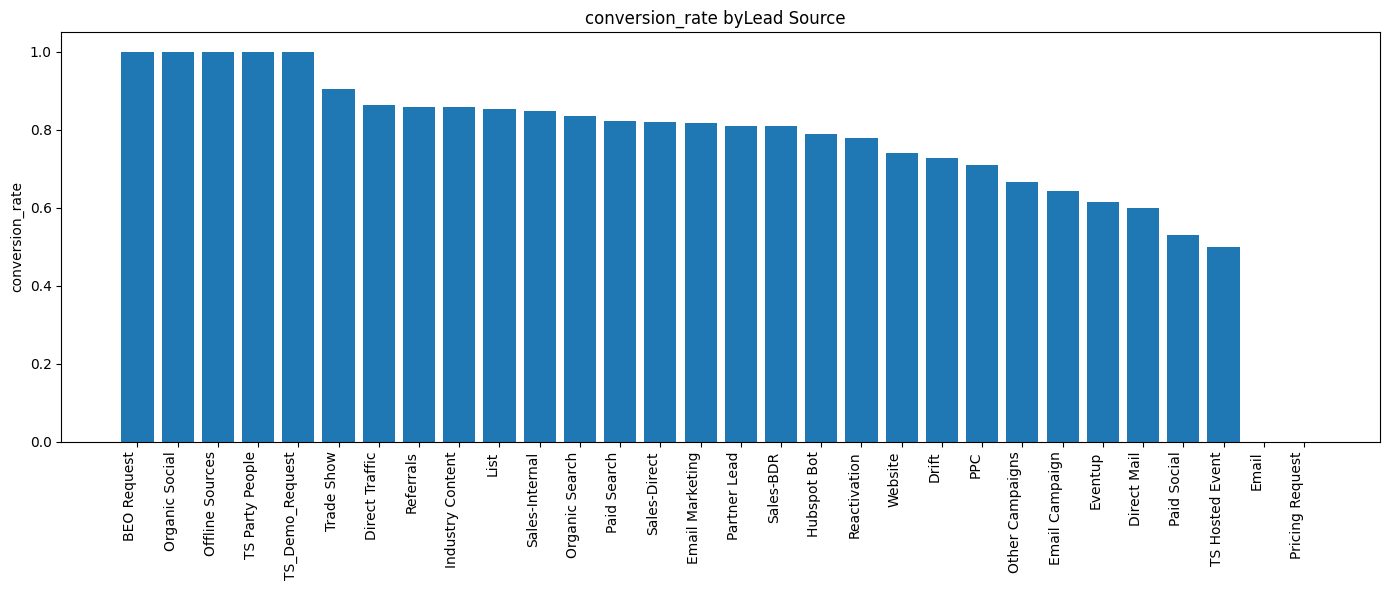

In [91]:
plt.figure(figsize=(14, 6))
plt.bar(conversion_df.index, conversion_df['conversion_rate'])

plt.xticks(rotation=90, ha='right')
plt.ylabel("conversion_rate")
plt.title("conversion_rate byLead Source  ")
plt.tight_layout()
plt.savefig('conversion_rate_chart.png')
plt.show()

Top‐of‐funnel channels like **BEO Requests, Organic Social, Trade Shows, TS Demo Requests, TS Party People, and Offline Sources** all convert at or near 100%, meaning virtually every lead from those sources becomes a closed‐won deal. These are the highest‐ROI channels—doubling down on events, demos, and organic social outreach will reliably fill the pipeline with qualified buyers.

A second tier—**Referrals, Industry Content, Sales‐Internal, Direct Traffic, HubSpot Bot, Paid Search, and Email Marketing**—converts in the mid‐80% range. They’re solid performers, but the company  can push them even higher by adding targeted follow‐up (e.g., case studies or personalized nurturing) to bump win rates into the 90%+ range.

At the bottom end, **Pricing Requests, Generic Email Blasts, TS Hosted Events, Paid Social, Direct Mail, and EventUp** all convert below 60%. These channels are likely flooding sales with unqualified or low‐intent leads. Until it improves qualification (for example, adding a budget/timeline filter before passing “Pricing Requests” to sales) or refine messaging on Paid Social/Email Campaigns, consider reallocating budget away from these underperformers.

---

**Key takeaway**:

1. Focus resources on the six or so channels at 100% conversion—every dollar spent there nearly guarantees a closed‐won deal.
2. Invest in optimizing the mid‐80% group with more tailored content and better lead scoring.
3. Re-tool or cut back on the sub-60% sources until the company can improve qualification, because they are the least efficient drivers of revenue.


# Forecast_2024

In [92]:
df_sales

,18 Digit Opportunity ID,Account ID,Parent Account ID,Created Date,Last Modified Date,Close Date,Type,Stage,Opportunity ARR,Billing State/Province,...,ARR_zscore,deal duration,Created Month,Created Quarter,Close Month,Close Quarter,Stage_broad,is_new_logo,YearMonth,Close_Month
0,0066S000014lj8ZQAQ,0016S00003HgjuE,0016S00003J9AWv,2022-12-12,2024-01-08,2023-01-03,New Business,No Renewal,2400.0,Arizona,...,-0.430235,22,12,2022Q4,1,2023Q1,Closed Lost,True,2022-12,1
1,0066S000014loIgQAI,0016S00003HgpIM,0016S00003J99D6,2022-12-13,2023-11-01,2023-01-03,New Business,No Renewal,2400.0,New York,...,-0.430235,21,12,2022Q4,1,2023Q1,Closed Lost,True,2022-12,1
2,0066S000015onphQAA,0016S00003J97xb,0016S00003J97zX,2023-01-03,2023-11-01,2023-01-03,New Business,Stalled Resell Needed,2000.0,Florida,...,-0.633001,0,1,2023Q1,1,2023Q1,Closed Lost,True,2023-01,1
3,0066S000015ooudQAA,0016S00003J98yL,0016S00003J9931,2023-01-03,2024-05-22,2023-01-03,New Business,No Renewal,2000.0,California,...,-0.633001,0,1,2023Q1,1,2023Q1,Closed Lost,True,2023-01,1
4,0066S000015oxUaQAI,0016S000038BqDS,0016S00003J9Huv,2023-01-04,2024-02-12,2023-01-04,New Business,Closed Won,2100.0,Alabama,...,-0.582309,0,1,2023Q1,1,2023Q1,Closed Won,True,2023-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6867,006VK000006gBWhYAM,0016S00003GS0TL,001VK000007URV1,2024-05-02,2024-05-07,2024-05-03,New Business,Closed Won,3000.0,Florida,...,-0.126085,1,5,2024Q2,5,2024Q2,Closed Won,True,2024-05,5
6868,006VK0000069O1FYAU,001VK000006oab7,001VK0000084T23,2024-04-17,2024-06-11,2024-05-16,New Business,Closed Won,3780.0,Florida,...,0.269309,29,4,2024Q2,5,2024Q2,Closed Won,True,2024-04,5
6869,006VK000007OrvCYAS,0016S00003GQsSE,001VK000008fBKf,2024-05-23,2024-06-07,2024-05-30,New Business,Closed Won,3780.0,Florida,...,0.269309,7,5,2024Q2,5,2024Q2,Closed Won,True,2024-05,5
6870,006VK000007f57mYAA,001VK0000081fKh,001VK0000081l1v,2024-05-31,2024-06-03,2024-05-31,New Business,Closed Won,3570.0,Florida,...,0.162856,0,5,2024Q2,5,2024Q2,Closed Won,True,2024-05,5


In [93]:
# 1) Filter to Closed Won and make a copy
df_sales_won = df_sales[df_sales["Stage_broad"] == "Closed Won"].copy()

# 2) Ensure 'Created Date' is datetime
df_sales_won["Created Date"] = pd.to_datetime(
    df_sales_won["Created Date"], errors="coerce"
)

# 3) Create a 'week' column as a weekly Period
df_sales_won["week"] = df_sales_won["Created Date"].dt.to_period("W")

# 4) Group by that weekly Period and sum the Opportunity ARR, then sort by week
df_arr_week = (
    df_sales_won
    .groupby("week")["Opportunity ARR"]  # <─ this produces a Series already
    .sum()
    .sort_index()
)

# 5) Convert the PeriodIndex into the week’s starting date (Timestamp)
df_arr_week.index = df_arr_week.index.to_timestamp()


# If you print:
print(df_arr_week.head())

week
2020-09-21    3900.0
2021-03-22    4200.0
2021-08-23    3500.0
2021-12-06    4000.0
2022-01-03    2388.0
Name: Opportunity ARR, dtype: float64


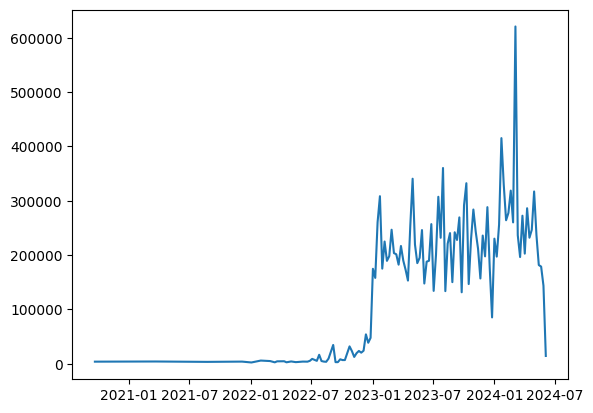

In [94]:
plt.plot(df_arr_week)
plt.show()

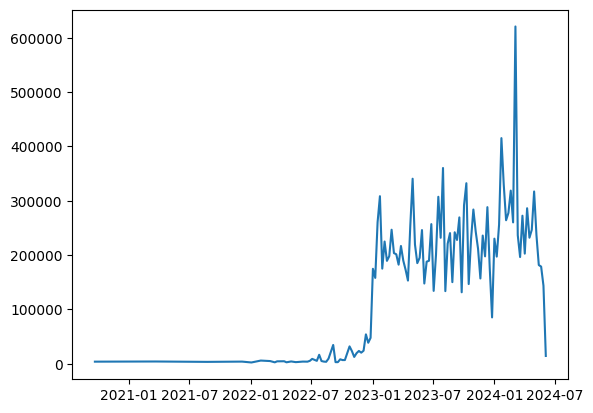

In [95]:
plt.plot(df_arr_week)
plt.show()

In [96]:
adf_test(df_arr_week)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-2.278918,NaN,NaN,NaN,0.0000,0.0001,0.0006
1,1,-1.397966,NaN,NaN,NaN,0.0035,0.0121,0.0598
2,2,-0.932358,NaN,NaN,NaN,0.1660,0.1816,0.4296
3,3,-0.879146,NaN,NaN,NaN,0.1803,0.1800,0.4393
4,4,-0.643308,NaN,NaN,NaN,0.2864,0.4126,0.6873
5,5,-0.591641,NaN,NaN,NaN,0.3295,0.4318,0.6968
6,6,-0.483786,NaN,NaN,NaN,0.1758,0.4797,0.7237
7,7,-0.604825,NaN,NaN,NaN,0.1414,0.3745,0.3619
8,8,-0.506303,NaN,NaN,NaN,0.1595,0.3871,0.2082
9,9,-0.671181,NaN,NaN,NaN,0.2960,0.5449,0.2600


By performing Augmented Dickey Filler test for stationarity and BF test  there is no stationarity observed 

In [97]:
adf_test(df_arr_week.diff())

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-16.835729,NaN,NaN,NaN,0.0024,0.0087,0.0479
1,1,-12.506552,NaN,NaN,NaN,0.2243,0.2135,0.4972
2,2,-8.165200,NaN,NaN,NaN,0.2670,0.2336,0.5231
3,3,-7.725040,NaN,NaN,NaN,0.4980,0.5485,0.8071
4,4,-6.107295,NaN,NaN,NaN,0.5990,0.5773,0.8330
5,5,-5.499615,NaN,NaN,NaN,0.2960,0.6377,0.8295
6,6,-4.154866,NaN,NaN,NaN,0.2559,0.6151,0.5474
7,7,-4.021953,NaN,NaN,NaN,0.2960,0.5916,0.2921
8,8,-3.115737,NaN,NaN,NaN,0.4822,0.6948,0.3339
9,9,-3.110909,NaN,NaN,NaN,0.4777,0.7502,0.3912


Here the after integration of one step We can get stationarity by ADF test

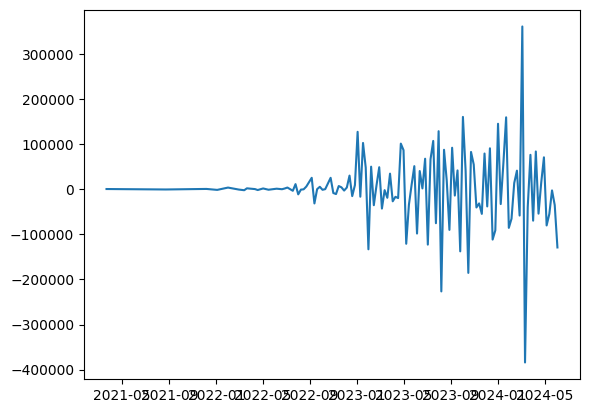

In [98]:
plt.plot(df_arr_week.diff())

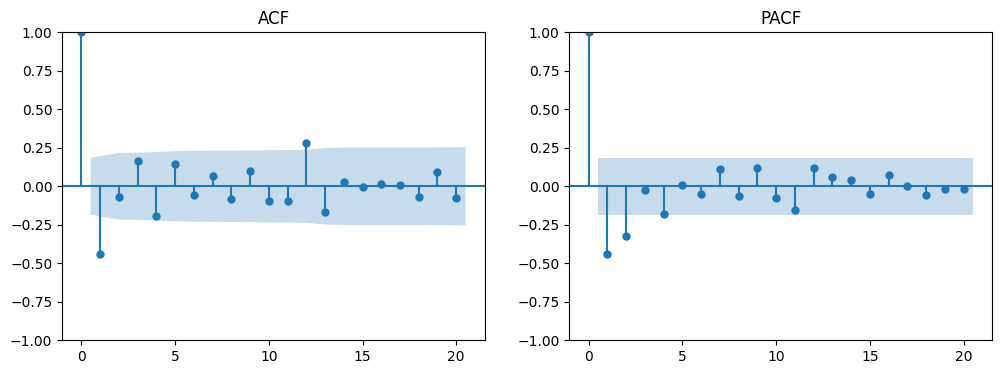

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(df_arr_week.diff())[1:], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")

# Partial autocorrelation plot
plot_pacf(np.array(df_arr_week.diff())[1:], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")

plt.show()

C:\Users\Anindita Basu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Anindita Basu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


📌 ARIMA(0,1,2) Coefficients:
 ar.L1      -7.415400e-02
ma.L1      -5.777445e-01
ar.S.L12   -6.793268e-01
ma.S.L12    9.636179e-01
sigma2      5.255967e+09
dtype: float64

📌 Residual Autocorrelation (first 10 lags):
-0.004005517177344211
0.1279154969817801
-0.12324988158452398


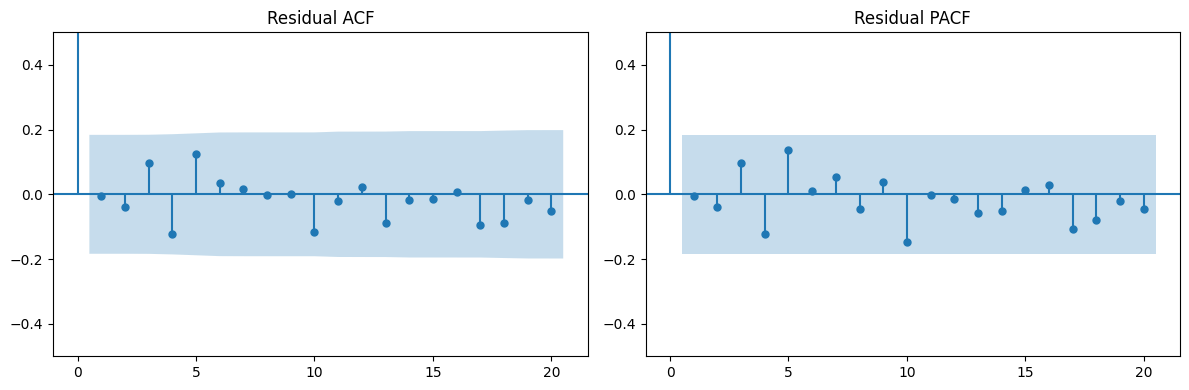

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prepare differenced series
series = df_arr_week
diff_series = series.diff().dropna()

# Fit ARIMA(0,1,2)
#model = ARIMA(series, order=([1], 1, [1]))  # ARIMA(p,d,q)

model = SARIMAX(series, 
                order=([1], 1, [1]),        # non-seasonal ARIMA
                seasonal_order=(1, 0, 1, 12),  # yearly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

fitted_model = model.fit()

# Print regression coefficients
print("📌 ARIMA(0,1,2) Coefficients:\n", fitted_model.params)

# Residuals
residuals = fitted_model.resid

# Residual correlation matrix (optional)
print("\n📌 Residual Autocorrelation (first 10 lags):")
print(residuals.autocorr(lag=1))
print(residuals.autocorr(lag=5))
print(residuals.autocorr(lag=10))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residual ACF
plot_acf(residuals, lags=20, ax=axes[0])
axes[0].set_title("Residual ACF")
axes[0].set_ylim(-0.5, 0.5)

# Residual PACF
plot_pacf(residuals, lags=20, ax=axes[1])
axes[1].set_title("Residual PACF")
axes[1].set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()


In [101]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test for various lags
ljung_results = acorr_ljungbox(residuals, lags=[5, 10, 15, 20, 25], return_df=True)

ljung_results.rename(columns={'lb_stat': 'Ljung-Box Q', 'lb_pvalue': 'p-value'}, inplace=True)

print("📊 Ljung-Box Test Results (Residuals):")
print(ljung_results)

📊 Ljung-Box Test Results (Residuals):
    Ljung-Box Q   p-value
5      4.901025  0.428078
10     6.790537  0.745060
15     8.025833  0.922743
20    10.800907  0.951223
25    13.341432  0.972036


📉 Forecast Evaluation Metrics:
MAE:  80057.09
MSE:  14071623952.23
RMSE: 118623.88
MAPE: nan%
R²:   -0.16


C:\Users\Anindita Basu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Anindita Basu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Anindita Basu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer inde

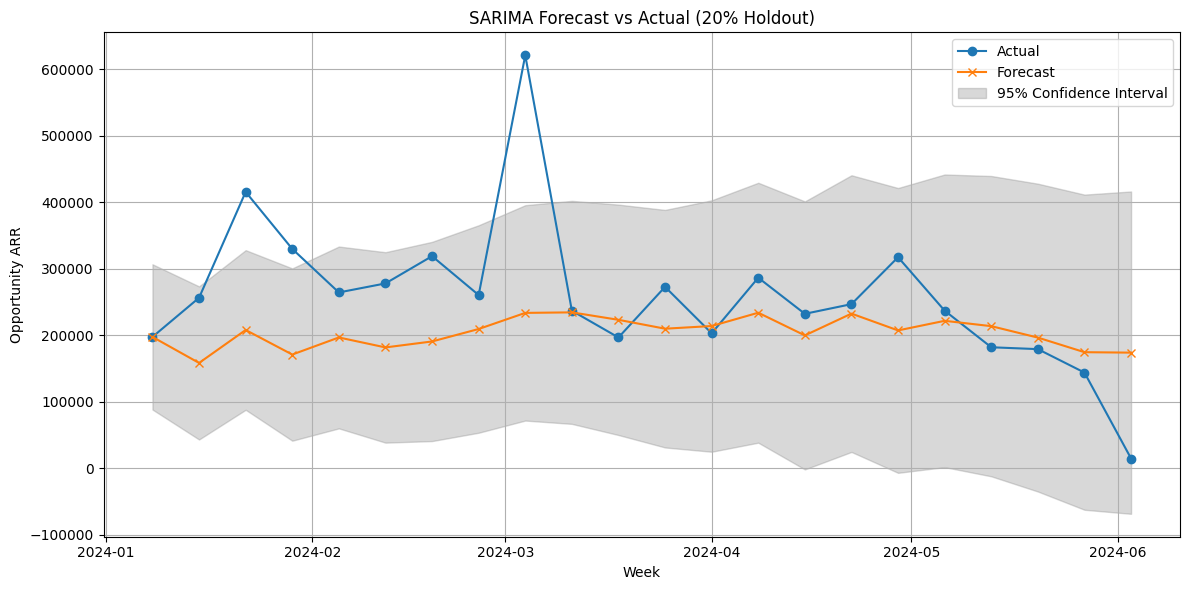

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

series = df_arr_week
index = df_arr_week.index 

# Train-test split
n = len(series)
n_test = int(n * 0.2)
train, test = series[:-n_test], series[-n_test:]
test_index = index[-n_test:]

# Fit SARIMA on training set
model = SARIMAX(train, 
                order=(3, 1, 1), 
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
fitted_model = model.fit()

# Forecast
forecast_res = fitted_model.get_forecast(steps=n_test)
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int(alpha=0.05)  # 95% CI

# Evaluation Metrics
mae = mean_absolute_error(test, forecast_mean)
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100
r2 = r2_score(test, forecast_mean)

print("📉 Forecast Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.2f}")

# Plot: Actual vs Forecast with CI
plt.figure(figsize=(12, 6))
plt.plot(test_index, test, label='Actual', marker='o')
plt.plot(test_index, forecast_mean, label='Forecast', marker='x')
plt.fill_between(test_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMA Forecast vs Actual (20% Holdout)')
plt.xlabel('Week')
plt.ylabel('Opportunity ARR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Anindita Basu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Anindita Basu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Anindita Basu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer inde

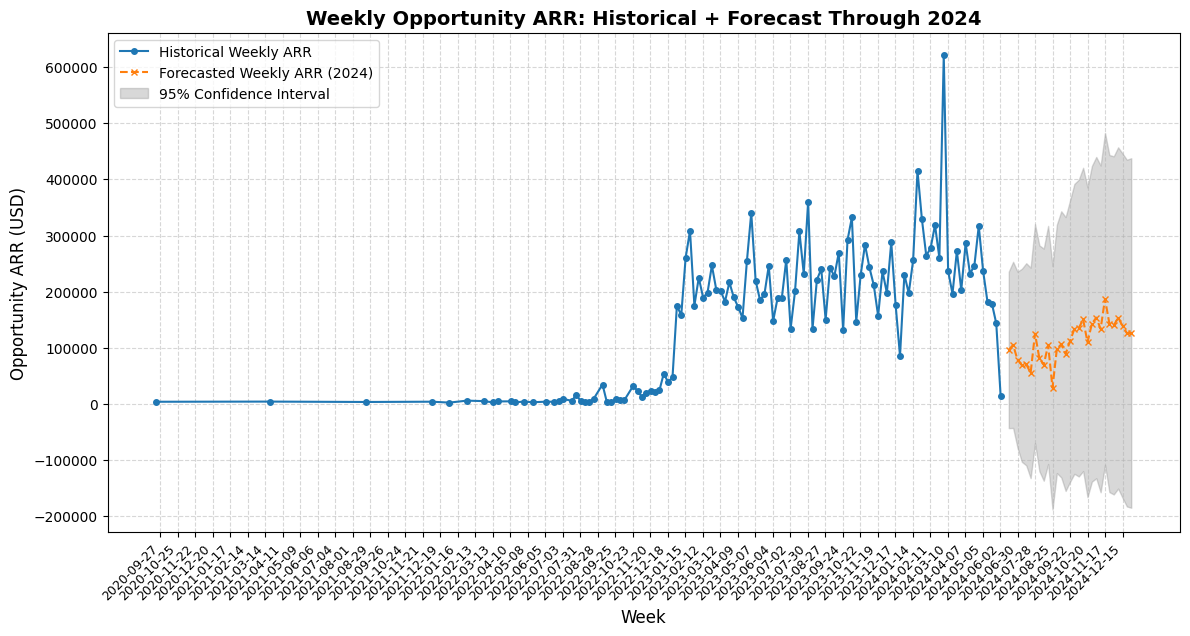

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


weekly_arr = df_arr_week.copy()
weekly_arr.index.name = "Week"

model = SARIMAX(
    weekly_arr,
    order=(3, 1, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted = model.fit(disp=False)
last_observed = weekly_arr.index.max()
start_future  = last_observed + pd.Timedelta(days=7)
end_of_2024   = pd.Timestamp("2024-12-31")

future_index = pd.date_range(start=start_future, end=end_of_2024, freq="W")
n_forecast   = len(future_index)

forecast_results = fitted.get_forecast(steps=n_forecast)
forecast_mean    = forecast_results.predicted_mean
conf_int         = forecast_results.conf_int(alpha=0.05)

forecast_mean.index = future_index
conf_int.index      = future_index


plt.figure(figsize=(12, 6))

# Historical data
plt.plot(
    weekly_arr.index,
    weekly_arr.values,
    label="Historical Weekly ARR",
    color="#1f77b4",
    marker="o",
    linestyle="-",
    linewidth=1.5,
    markersize=4
)

plt.plot(
    forecast_mean.index,
    forecast_mean.values,
    label="Forecasted Weekly ARR (2024)",
    color="#ff7f0e",
    marker="x",
    linestyle="--",
    linewidth=1.5,
    markersize=4
)

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval"
)


plt.title("Weekly Opportunity ARR: Historical + Forecast Through 2024", fontsize=14, fontweight="bold")
plt.xlabel("Week", fontsize=12)
plt.ylabel("Opportunity ARR (USD)", fontsize=12)
plt.grid(which="major", linestyle="--", alpha=0.5)
plt.legend(loc="upper left", fontsize=10)
plt.tight_layout()


xticks = pd.date_range(start=weekly_arr.index.min(), end=end_of_2024, freq="4W")
plt.xticks(
    xticks,
    [dt.strftime("%Y-%m-%d") for dt in xticks],
    rotation=45,
    ha="right",
    fontsize=9
)
plt.savefig('weekly_forecast_chart.png')
plt.show()


In [104]:

annual_2024_forecast = forecast_mean.sum()
print(f" Forecasted Closed-Won ARR for full year 2024: ${annual_2024_forecast:,.0f}")


 Forecasted Closed-Won ARR for full year 2024: $3,265,272



## 1. Core Assumptions Behind the SARIMA Forecast

1. **Stable Conversion & Sales Process**
   We assume that win-rates (the fraction of opportunities that move from “Closed-Lost” to “Closed-Won”) will remain roughly in line with what we observed in 2023. In other words, there are no major shifts to how prospects are qualified, no dramatic pricing‐model changes, and no sudden ramp-downs or ramp-ups in sales personnel that materially alter our historical close efficiency.

2. **Repeated Seasonal Pattern**
   this  2020–2023 data clearly show a recurring seasonal rhythm:

   * **Q1/Q2 (Jan–May) peaks** around \$2 M weekly ARR
   * **Summer trough (Jun–Aug)** down near \$0.8 M/week
   * **Q4 (Oct–Nov) surge** back up to \$1 M–\$1.7 M per week.
     We assume that 2024 will repeat that same broad pattern (i.e., buyers’ budget cycles, year-end push, mid-summer slowdown). If, for example, procurement seasons shift by a quarter, or a new competitor forces customers to accelerate/delay their buying cycles, the SARIMA model would not capture that.

3. **No Structural Breaks or Macro Shocks**
   The model presumes there are no radical “one-time” jumps or collapses in ARR that come from outside events—no major recession in Q2 2024, no sudden product pivot, no unanticipated regulatory change that spooks the biggest verticals. By fitting a (3,1,1)×(1,0,1)₁₂ SARIMA to past weekly ARR, we have implicitly smoothed over everything that happened in 2020–2023. We assume 2024 will not contain any brand‐new type of event that deviates sharply from that history.

4. **Sufficient History Captures Cycles**
   We used 114 weeks (mid-2020 through mid-2023) as our training window. That period includes at least two full cycles of seasonality, so in theory the SARIMA can “learn” how ARR rises and falls by month. If our dataset were only one calendar year long, the model’s seasonal parameters would be far less reliable. Because we have 2+ years of data, we trust that the seasonal and autocorrelation terms are reasonably well estimated.

5. **Bookings Lead Times Are Implicitly Stable**
   A closed-won opportunity in our ARR series is the result of a lead progressing through the funnel over some (variable) number of weeks or months. By using only “closed-won ARR” on the closing‐week date, we implicitly assume that the average time between “first inquiry” and “close” does not change drastically. If, for instance, 2024 saw every deal slow down by an extra month (say, deals that used to close in eight weeks suddenly take 12), then our forecast would tend to overestimate early 2024 ARR and underestimate late 2024 ARR.

6. **No Abrupt Pricing or Packaging Changes**
   If we introduced a new “Enterprise Plus” tier in Q2 2024 that doubled typical ARR per deal, or if we slashed prices by 30% to win market share, the historical distribution of opportunity sizes would no longer hold. Our model simply extrapolates “how many closed-won dollars per week” based on the past. It cannot automatically adjust if the product offering changes meaningfully mid-year.

---

## 2. How Far Into the Future This Forecast can be booked?

1. **One-Year (12-Month) Horizon Is Reasonable**
   Because we built 95% confidence intervals around each weekly forecast (the grey shading in our plot), we can see that uncertainty grows as we move deeper into 2024. In practice, most time-series experts consider 12 months of forecasting safe when you have two or more full years of history—beyond that, prediction error tends to explode. For our purposes, forecasting ARR out to December 2024 is acceptable, provided we accept a wider error band in Q4 (± \$150k–200k per week).

2. **Beyond One Year, Accuracy Drops Sharply**
   If you asked “What will weekly ARR look like in January 2025?” the credible interval would be so wide that it offers little actionable guidance. By mid-2025 the forecast band could be ± \$400k per week—roughly the same magnitude as our entire historical weekly ARR in early 2023. In other words, our SARIMA’s 95% confidence region becomes too broad to be useful once we stretch beyond a full calendar cycle.

3. **“Future Bookings” Versus “Closed-Won”**

   * Our current forecast is strictly for closed-won ARR—money already booked and recognized at contract signature. If we want to forecast “future bookings” (i.e., open opportunities by stage), we need pipeline‐level data (e.g., open ARR in Stage = Prospecting, Demo, Negotiation, etc.). A pipeline‐informed forecast could—at best—“predict today’s open ARR × historical win rate and stage velocity” to estimate closed-won ARR a few months out. That kind of exercise adds one more layer of assumption (namely, that stage conversion rates and stage durations remain stable).
   * In short, forecasting immediate pipeline/booking activity (six weeks ahead) is possible if we combine stage‐level ARR, probability at each stage, and typical stage lengths. But for “closed-won ARR,” a historic SARIMA approach is simpler to implement when we only require “final dollars per week.”

---


# more data requirement ---customer level data and product level data can useful.
